# Pachete necesare pentru folosirea acestui Notebook

Vom folosi [scipy](https://scipy.org/), [numpy](https://numpy.org/) și [matplotlib](https://matplotlib.org/).

In [179]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import datasets, ndimage
from scipy.fft import dctn, idctn
import imageio as iio
import tqdm

# Imaginea cu care lucrăm

Vom folosi o imagine din setul de date oferit implicit de către scipy.

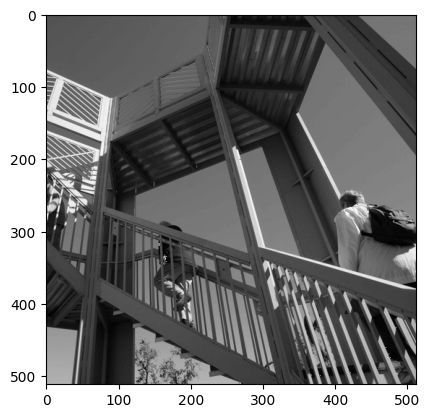

In [180]:
X = datasets.ascent()
plt.imshow(X, cmap=plt.cm.gray)
plt.show()

# Transformata DCT a unei imagini

Transformata DCT se extinde la mai multe dimensiuni similar cu transformata DFT. Pentru un semnal bidimensional, precum o imagine, DCT-II devine:

$$
Y_{m_1,m_2} = \sum_{n_1=0}^{N_1-1}
              \sum_{n_2=0}^{N_2-1}
              x_{n_1,n_2}
              \cos\left[\frac{\pi}{N_1}m_1
                \left(n_1 + \frac12\right)\right]
              \cos\left[\frac{\pi}{N_2}m_2\left(n_2 + \frac12\right)\right]
$$

* unde $n_1$ și $n_2$ sunt pozițile pixelilor pe orizontală, respectiv, pe verticală
* bin-urile rezultate corespund pozițiilor pixelilor
* spectrul este în continuare simetric și par
* proprietățile transformatei DCT-II sunt respectate și în cazul celei 2D

În Python avem rutina `scipy.fft.dct` pentru 1D și `scipy.fft.dctn` pentru generalizarea la semnale $n$-dimensionale. Dimensiunea este determinată automat după forma semnalului; tipul DCT poate fi specificat prin atributul `type` (implicit II).

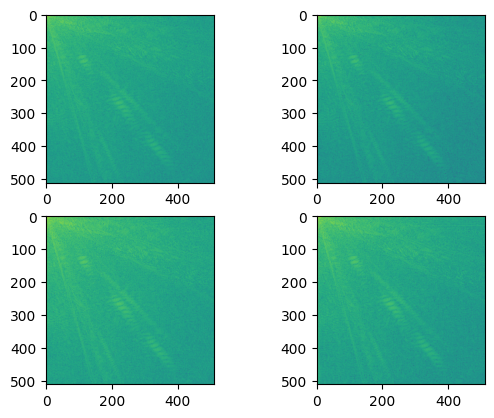

In [181]:
Y1 = dctn(X, type=1)
Y2 = dctn(X, type=2)
Y3 = dctn(X, type=3)
Y4 = dctn(X, type=4)
freq_db_1 = 20*np.log10(abs(Y1))
freq_db_2 = 20*np.log10(abs(Y2))
freq_db_3 = 20*np.log10(abs(Y3))
freq_db_4 = 20*np.log10(abs(Y4))

plt.subplot(221).imshow(freq_db_1)
plt.subplot(222).imshow(freq_db_2)
plt.subplot(223).imshow(freq_db_3)
plt.subplot(224).imshow(freq_db_4)
plt.show()

# Compactarea energiei. Compresie.

Putem profita de proprietatea compresiei energiei prin anularea frecvențelor DCT începând cu *bin*-ul `k` după care aplicăm transformata DCT inversă (similar cu tema anterioară):

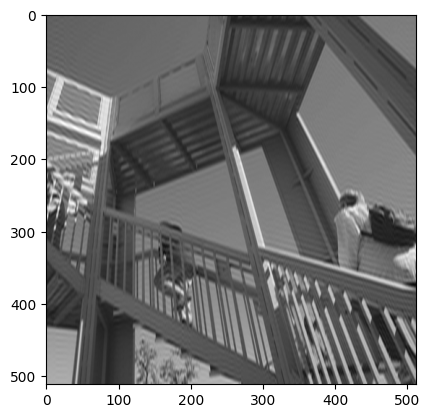

In [182]:
k = 120

Y_ziped = Y2.copy()
Y_ziped[k:] = 0
X_ziped = idctn(Y_ziped)

plt.imshow(X_ziped, cmap=plt.cm.gray)
plt.show()

# JPEG

Algoritmul de compresie JPEG are patru etape:

1. transformarea imaginii din pixeli RGB în Y'CbCr
2. aplicarea 2D-DCT pe blocuri disincte de 8x8 pixeli din imagine
3. cuantizarea în frecvență cu $Q$ dat de standardul JPEG
4. compresia rezultatului cu coduri Huffman

Unde matricea JPEG de cuantizare $Q$ este:
$$
Q =
\begin{bmatrix}
16 & 11 & 10 & 16 & 24 & 40 & 51 & 61 & \\
12 & 12 & 14 & 19 & 26 & 28 & 60 & 55 & \\
14 & 13 & 16 & 24 & 40 & 57 & 69 & 56 & \\
14 & 17 & 22 & 29 & 51 & 87 & 80 & 62 & \\
18 & 22 & 37 & 56 & 68 & 109 & 103 & 77 & \\
24 & 35 & 55 & 64 & 81 & 104 & 113 & 92 & \\
49 & 64 & 78 & 87 & 103 & 121 & 120 & 101\\
72 & 92 & 95 & 98 & 112 & 100 & 103 & 99\\
\end{bmatrix}
$$

Imaginea noastră de test este monocromă, deci nu necesită pasul 1, dar putem efectua o operație de *down-sampling* în preprocesare precum am prezentat la curs.

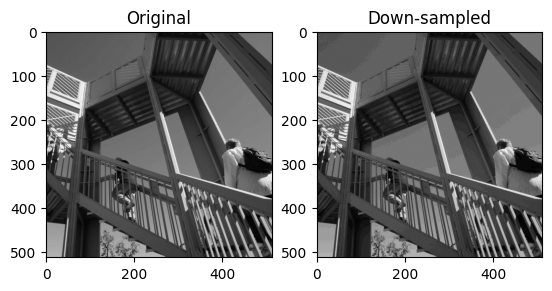

In [183]:
Q_down = 10

X_jpeg = X.copy()
X_jpeg = Q_down*np.round(X_jpeg/Q_down);

plt.subplot(121).imshow(X, cmap=plt.cm.gray)
plt.title('Original')
plt.subplot(122).imshow(X_jpeg, cmap=plt.cm.gray)
plt.title('Down-sampled')
plt.show()

Pentru fiecare bloc de $8\times 8$ aplică DCT și cuantizare.

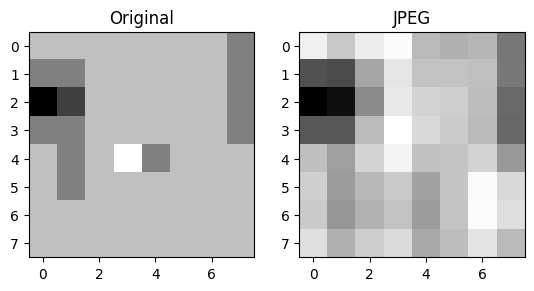

Componente în frecvență:64
Componente în frecvență după cuantizare: 14


In [184]:
Q_jpeg = [[16, 11, 10, 16, 24, 40, 51, 61],
          [12, 12, 14, 19, 26, 28, 60, 55],
          [14, 13, 16, 24, 40, 57, 69, 56],
          [14, 17, 22, 29, 51, 87, 80, 62],
          [18, 22, 37, 56, 68, 109, 103, 77],
          [24, 35, 55, 64, 81, 104, 113, 92],
          [49, 64, 78, 87, 103, 121, 120, 101],
          [72, 92, 95, 98, 112, 100, 103, 99]]

# Encoding
x = X[:8, :8]
y = dctn(x)
y_jpeg = Q_jpeg*np.round(y/Q_jpeg)

# Decoding
x_jpeg = idctn(y_jpeg)

# Results
y_nnz = np.count_nonzero(y)
y_jpeg_nnz = np.count_nonzero(y_jpeg)

plt.subplot(121).imshow(x, cmap=plt.cm.gray)
plt.title('Original')
plt.subplot(122).imshow(x_jpeg, cmap=plt.cm.gray)
plt.title('JPEG')
plt.show()

print('Componente în frecvență:' + str(y_nnz) + 
      '\nComponente în frecvență după cuantizare: ' + str(y_jpeg_nnz))

# Sarcini

1. [6p] Completați algoritmul JPEG incluzând toate blocurile din imagine.

2. [4p] Extindeți la imagini color (incluzând transformarea din RGB în Y'CbCr).

3. [6p] Extindeți algoritmul pentru compresia imaginii până la un prag MSE impus de utilizator.

4. [4p] Extindeți algoritmul pentru compresie video. Demonstrați pe un clip scurt din care luați fiecare cadru și îl tratați ca pe o imagine.

Componente în frecvență: 262144
Componente în frecvență după cuantizare: 37090
Raport: 7.07x


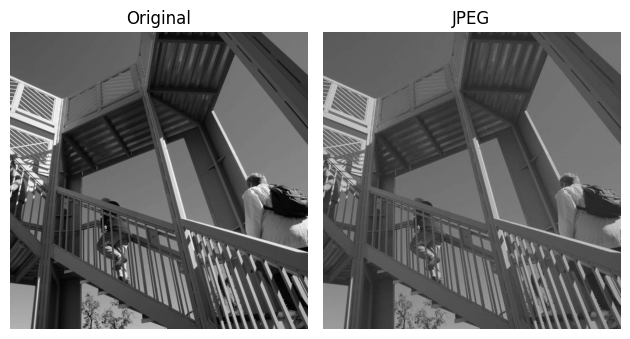

In [185]:
# 1: grayscale jpeg
Q_jpeg = [[16, 11, 10, 16, 24, 40, 51, 61],
          [12, 12, 14, 19, 26, 28, 60, 55],
          [14, 13, 16, 24, 40, 57, 69, 56],
          [14, 17, 22, 29, 51, 87, 80, 62],
          [18, 22, 37, 56, 68, 109, 103, 77],
          [24, 35, 55, 64, 81, 104, 113, 92],
          [49, 64, 78, 87, 103, 121, 120, 101],
          [72, 92, 95, 98, 112, 100, 103, 99]]

# Crop to have image size as multiples of 8
h, w = X.shape
h = (h // 8) * 8
w = (w // 8) * 8
X = X[:h, :w]

# Split in blocks (Y -> X, then transpose to select blocks then pixels)
blocks = X.reshape(h // 8, 8, w // 8, 8).transpose(0, 2, 1, 3)

# Encoding
dct_blocks = dctn(blocks, axes=(2, 3), norm='ortho')
dct_quantized = Q_jpeg * np.round(dct_blocks / Q_jpeg)

# Decoding
idct_blocks = idctn(dct_quantized, axes=(2, 3), norm='ortho')

# Reconstruction (inverse of splitting in blocks, otherwise its fubar)
blocks = X.reshape(h // 8, 8, w // 8, 8).transpose(0, 2, 1, 3)
X_jpeg = idct_blocks.transpose(0, 2, 1, 3).reshape(h, w)

# Results
total_coeffs = dct_blocks.size
non_zeros = np.count_nonzero(dct_quantized)
compression_ratio = total_coeffs / non_zeros

print(f"Componente în frecvență: {total_coeffs}")
print(f"Componente în frecvență după cuantizare: {non_zeros}")
print(f"Raport: {compression_ratio:.2f}x")

plt.subplot(121)
plt.imshow(X, cmap='gray')
plt.title('Original')
plt.axis('off')

plt.subplot(122)
plt.imshow(X_jpeg, cmap='gray')
plt.title(f'JPEG')
plt.axis('off')

plt.savefig('artifacts/tema_1_ex_1_plot.pdf')

plt.tight_layout()
plt.show()

Componente în frecvență: 262144
Componente în frecvență după cuantizare: 37090
Raport: 7.07x


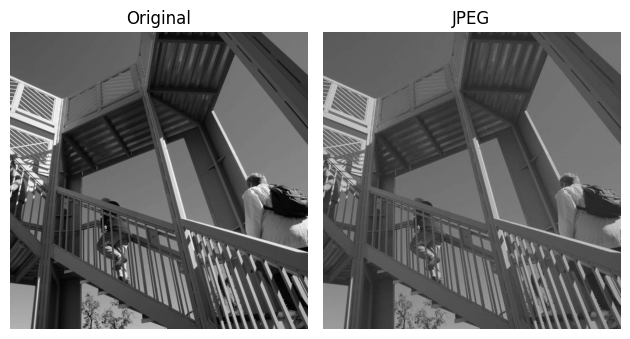

In [186]:
# 1: grayscale jpeg
Q_jpeg = np.array(
          [[16, 11, 10, 16, 24, 40, 51, 61],
          [12, 12, 14, 19, 26, 28, 60, 55],
          [14, 13, 16, 24, 40, 57, 69, 56],
          [14, 17, 22, 29, 51, 87, 80, 62],
          [18, 22, 37, 56, 68, 109, 103, 77],
          [24, 35, 55, 64, 81, 104, 113, 92],
          [49, 64, 78, 87, 103, 121, 120, 101],
          [72, 92, 95, 98, 112, 100, 103, 99]])

def jpeg(X, Q_jpeg):
    # Crop to have image size as multiples of 8
    h, w = X.shape
    h = (h // 8) * 8
    w = (w // 8) * 8
    X = X[:h, :w]

    # Split in blocks (Y -> X, then transpose to select blocks then pixels)
    blocks = X.reshape(h // 8, 8, w // 8, 8).transpose(0, 2, 1, 3)

    # Encoding
    dct_blocks = dctn(blocks, axes=(2, 3), norm='ortho')
    dct_quantized = Q_jpeg * np.round(dct_blocks / Q_jpeg)

    # Decoding
    idct_blocks = idctn(dct_quantized, axes=(2, 3), norm='ortho')

    # Reconstruction (inverse of splitting in blocks, otherwise its fubar)
    blocks = X.reshape(h // 8, 8, w // 8, 8).transpose(0, 2, 1, 3)
    X_jpeg = idct_blocks.transpose(0, 2, 1, 3).reshape(h, w)

    # Results
    total_coeffs = dct_blocks.size
    non_zeros = np.count_nonzero(dct_quantized)
    compression_ratio = total_coeffs / non_zeros

    return (X_jpeg, total_coeffs, non_zeros, compression_ratio)

X_jpeg, total_coeffs, non_zeros, compression_ratio = jpeg(X, Q_jpeg)
print(f"Componente în frecvență: {total_coeffs}")
print(f"Componente în frecvență după cuantizare: {non_zeros}")
print(f"Raport: {compression_ratio:.2f}x")

plt.subplot(121)
plt.imshow(X, cmap='gray')
plt.title('Original')
plt.axis('off')

plt.subplot(122)
plt.imshow(X_jpeg, cmap='gray')
plt.title(f'JPEG')
plt.axis('off')

plt.savefig('artifacts/tema_1_ex_1_plot.pdf')

plt.tight_layout()
plt.show()

Componente în frecvență: 2359296
Componente în frecvență după cuantizare: 154071
Raport: 15.31x


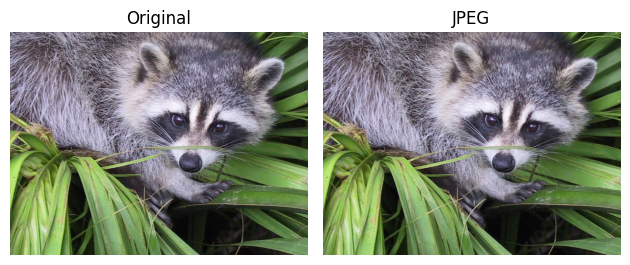

In [187]:
# 2: colour jpeg
def rgb2ycbcr(X):
    # standard ITU-R BT.601
    xform = np.array([[.299, .587, .114],
                      [-.1687, -.3313, .5],
                      [.5, -.4187, -.0813]])
    ycbcr = X.dot(xform.T)
    ycbcr[:,:,[1,2]] += 128
    return ycbcr

def ycbcr2rgb(X):
    xform = np.array([[1, 0, 1.402],
                      [1, -0.34414, -.71414],
                      [1, 1.772, 0]])
    rgb = X.astype(float)
    rgb[:,:,[1,2]] -= 128
    rgb = rgb.dot(xform.T)
    return np.clip(rgb, 0, 255).astype(np.uint8)

X = datasets.face()

def ch_jpeg(X, Q_jpeg):
    if X.ndim != 3 or X.shape[2] != 3:
        raise TypeError('X must be a 3-dimensional array representing a RGB image')
    X_ycbcr = rgb2ycbcr(X)
    channels = X_ycbcr.transpose(2, 0, 1)
    results = [jpeg(layer, Q_jpeg) for layer in channels]

    jpeg_channels = np.array([res[0] for res in results])
    total_coeffs  = sum(res[1] for res in results)
    non_zeros     = sum(res[2] for res in results)
    compression_ratio = total_coeffs / non_zeros

    X_jpeg = ycbcr2rgb(jpeg_channels.transpose(1, 2, 0))

    return X_jpeg, total_coeffs, non_zeros, compression_ratio

X_jpeg, total_coeffs, non_zeros, compression_ratio = ch_jpeg(X, Q_jpeg)
print(f"Componente în frecvență: {total_coeffs}")
print(f"Componente în frecvență după cuantizare: {non_zeros}")
print(f"Raport: {compression_ratio:.2f}x")

plt.subplot(121)
plt.imshow(X)
plt.title('Original')
plt.axis('off')

plt.subplot(122)
plt.imshow(X_jpeg)
plt.title(f'JPEG')
plt.axis('off')

plt.savefig('artifacts/tema_1_ex_2_plot.pdf')

plt.tight_layout()
plt.show()


Iter 0: Alpha=5.05, MSE=333.88
Iter 1: Alpha=2.58, MSE=132.46
Iter 2: Alpha=1.35, MSE=56.05
Iter 3: Alpha=0.73, MSE=27.41
Iter 4: Alpha=1.04, MSE=46.01
Iter 5: Alpha=1.19, MSE=50.94
Iter 6: Alpha=1.11, MSE=48.50
Iter 7: Alpha=1.15, MSE=49.07
Iter 8: Alpha=1.17, MSE=49.48
Iter 9: Alpha=1.18, MSE=49.89
Iter 10: Alpha=1.19, MSE=49.89
Iter 11: Alpha=1.19, MSE=50.94
Iter 12: Alpha=1.19, MSE=50.95
Iter 13: Alpha=1.19, MSE=49.89
Iter 14: Alpha=1.19, MSE=50.95
Iter 15: Alpha=1.19, MSE=50.95
Iter 16: Alpha=1.19, MSE=50.95
Iter 17: Alpha=1.19, MSE=50.95
Iter 18: Alpha=1.19, MSE=50.95
Iter 19: Alpha=1.19, MSE=50.95
Componente în frecvență: 2359296
Componente în frecvență după cuantizare: 151283
Alpha: 1.19, MSE: 49.89
Raport: 15.60x


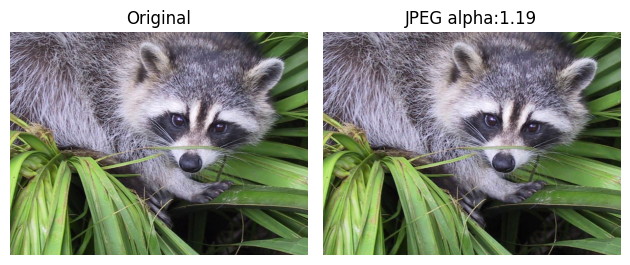

In [188]:
# 3: jpeg w/ mse threshold

def calculate_mse(original, reconstructed):
    err = np.sum((original.astype("float") - reconstructed.astype("float")) ** 2)
    err /= float(original.shape[0] * original.shape[1])
    return err

def find_optimal_compression(X, target_mse, max_iterations=20):
    Q_base = Q_jpeg
    low = 0.11
    high = 10.0

    best_X = None
    best_alpha = low
    final_mse = 0
    final_total = 0
    final_non_zeros = 0
    final_compression_ratio = 0

    if X.ndim != 3 or X.shape[2] != 3:
        if X.ndim == 2:
            pipeline = jpeg
        else:
            raise TypeError('X must be a 3-dimensional array representing a RGB image or a 2-dimensional array representing a grayscale image')
    else:
        pipeline = ch_jpeg

    current_X = None
    current_total = 0
    current_non_zeros = 0
    current_ratio = 0
    current_mse = 0

    for i in range(max_iterations):
        mid = (low + high) / 2
        Q_current = np.floor(Q_base * mid)
        Q_current[Q_current == 0] = 1

        current_X, current_total, current_non_zeros, current_ratio = pipeline(X, Q_current)
        current_mse = calculate_mse(X, current_X)

        print(f"Iter {i}: Alpha={mid:.2f}, MSE={current_mse:.2f}")

        if current_mse <= target_mse:
            best_X = current_X
            best_alpha = mid
            final_mse = current_mse
            final_total = current_total
            final_non_zeros = current_non_zeros
            final_compression_ratio = current_ratio
            low = mid
        else:
            high = mid

    if best_X is None:
        print("Warning: Target MSE not met. Returning last iteration result.")
        return current_X, mid, current_mse, current_total, current_non_zeros, current_ratio

    return best_X, best_alpha, final_mse, final_total, final_non_zeros, final_compression_ratio

X_jpeg, alpha, mse, total_coeffs, non_zeros, compression_ratio = find_optimal_compression(X, 50, 20)
print(f"Componente în frecvență: {total_coeffs}")
print(f"Componente în frecvență după cuantizare: {non_zeros}")
print(f"Alpha: {alpha:.2f}, MSE: {mse:.2f}")
print(f"Raport: {compression_ratio:.2f}x")

plt.subplot(121)
plt.imshow(X, cmap='gray')
plt.title('Original')
plt.axis('off')

plt.subplot(122)
plt.imshow(X_jpeg, cmap='gray')
plt.title(f'JPEG alpha:{alpha:.2f}')
plt.axis('off')

plt.savefig('artifacts/tema_1_ex_3_plot.pdf')

plt.tight_layout()
plt.show()

In [189]:
# 4: video jpeg
frames = iio.v3.imread('imageio:cockatoo.mp4')
iio.v3.imwrite('artifacts/cockatoo_original.mp4', frames, fps=30)

global_coeffs = 0
global_non_zeros = 0
frames_jpeg = []

pbar = tqdm.tqdm(frames, desc="Video JPEG", unit="frame")

for frame in pbar:
    rec_frame, t_coeffs, t_non_zeros, _ = ch_jpeg(frame, Q_jpeg)

    frames_jpeg.append(rec_frame.astype(np.uint8))
    global_coeffs += t_coeffs
    global_non_zeros += t_non_zeros

    ratio = global_coeffs / global_non_zeros if global_non_zeros > 0 else 0
    pbar.set_postfix({"Avg Ratio": f"{ratio:.2f}x"})

iio.v3.imwrite('artifacts/cockatoo_jpeg.mp4', np.array(frames_jpeg), fps=30)

final_ratio = global_coeffs / global_non_zeros if global_non_zeros > 0 else 0
print(f"Total coeficienți:      {global_coeffs:,}")
print(f"Total după cuantizare:  {global_non_zeros:,}")
print(f"Raport mediu:           {final_ratio:.2f}x")

Video JPEG: 100%|██████████| 280/280 [00:33<00:00,  8.35frame/s, Avg Ratio=39.65x]


Total coeficienți:      774,144,000
Total după cuantizare:  19,522,313
Raport mediu:           39.65x
